In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import time
import dask.array as da
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

from distributed import Client
from dask.array.routines import matmul_org, matmul
from dask.distributed import wait, progress
from dask.diagnostics import ResourceProfiler

In [3]:
from plotly import io as pio
pio.renderers.default = "png+plotly_mimetype"

In [4]:
# holds dask client
c = None

In [5]:
def get_dask_cluster(n_workers=1):
    # By default we use a single separate process to get fresh memory
    # stats on each client. GIL shouln't be a problem in this pipeline,
    # also org matmul runs out of memory when there is more processes to
    # split the memory (for larger inputs)
    c and c.shutdown()
    # when we shutdown the cluster, there is an exception message after 10s
    # to keep it clean, let's sleep a bit
    time.sleep(11)
    return Client(n_workers=n_workers)

In [6]:
def get_data(n: int, m: int, chunks=(1000, 250)):
    X = da.random.random(size=(n, m), chunks=chunks)
    Y = da.random.random(size=(n, 3), chunks=(chunks[0], -1))
    return X, Y

def perf_test(matmul_fn, X, Y):
    """Perf test is transposition, followed by multiplication and max"""
    with ResourceProfiler() as prof:
        R = matmul_fn(X.T, Y)
        result = R.max().compute()
    return result, prof

def perf_suite(matmul_fn):
    """Here we test the impact of the size of the contraction axis"""
    results = []
    for n in 10**np.array([3, 3.5, 4, 4.5, 5, 5.5, 6]):
        m = 1000
        X, Y = get_data(int(n), m)
        _, prof = perf_test(matmul_fn, X, Y)
        results.append((m, n, prof.results))

    return pd.DataFrame([
        dict(m=r[0], n=r[1], mem=e.mem)
        for r in results
        for e in r[2]
    ])

## Original matmul results

In [7]:
c = get_dask_cluster()
c

Client Scheduler: tcp://127.0.0.1:49812 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [8]:
%%time
master_df = perf_suite(matmul_org)

CPU times: user 6.64 s, sys: 465 ms, total: 7.11 s
Wall time: 23.8 s


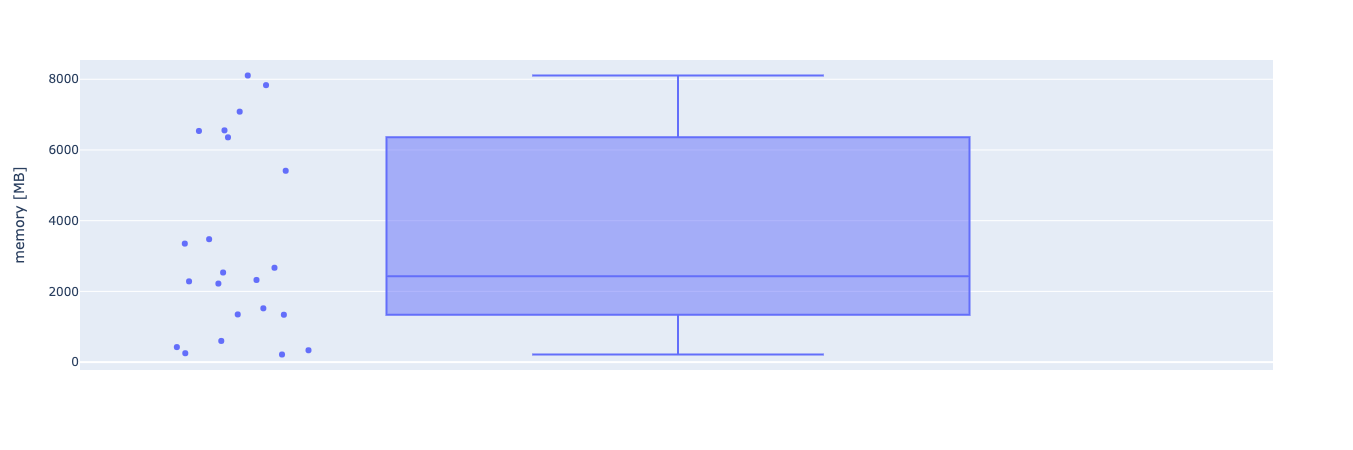

In [9]:
px.box(master_df, y="mem", points="all", labels={"mem": "memory [MB]"})

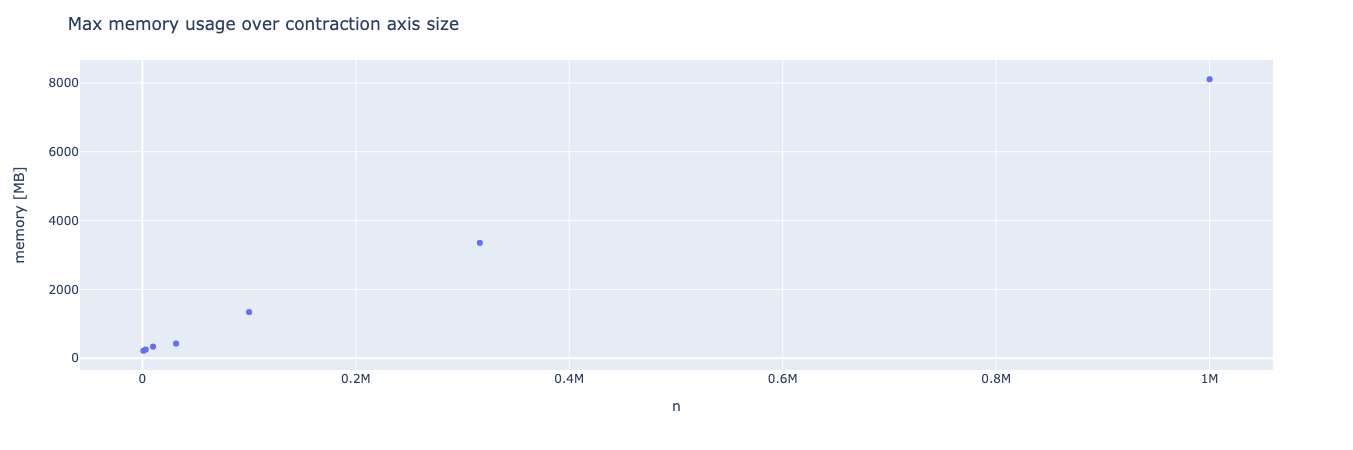

In [10]:
f = px.scatter(master_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")

The memory footprint goes up as we increase the size of the input, this is due to the concatenated contraction happening in the blockwise, which forces more data to be materialized.

## New matmul results

In [11]:
# Restart the dask cluster to start from clean state
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:50327 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [12]:
%%time
new_df = perf_suite(matmul)

CPU times: user 8.89 s, sys: 548 ms, total: 9.43 s
Wall time: 26.9 s


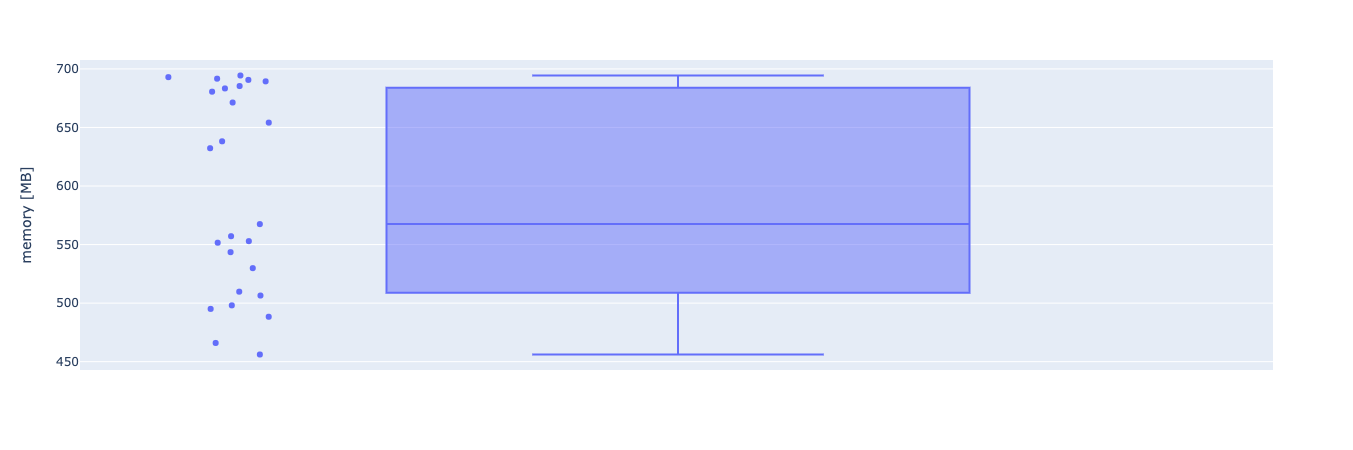

In [13]:
px.box(new_df, y="mem", points="all", labels={"mem": "memory [MB]"})

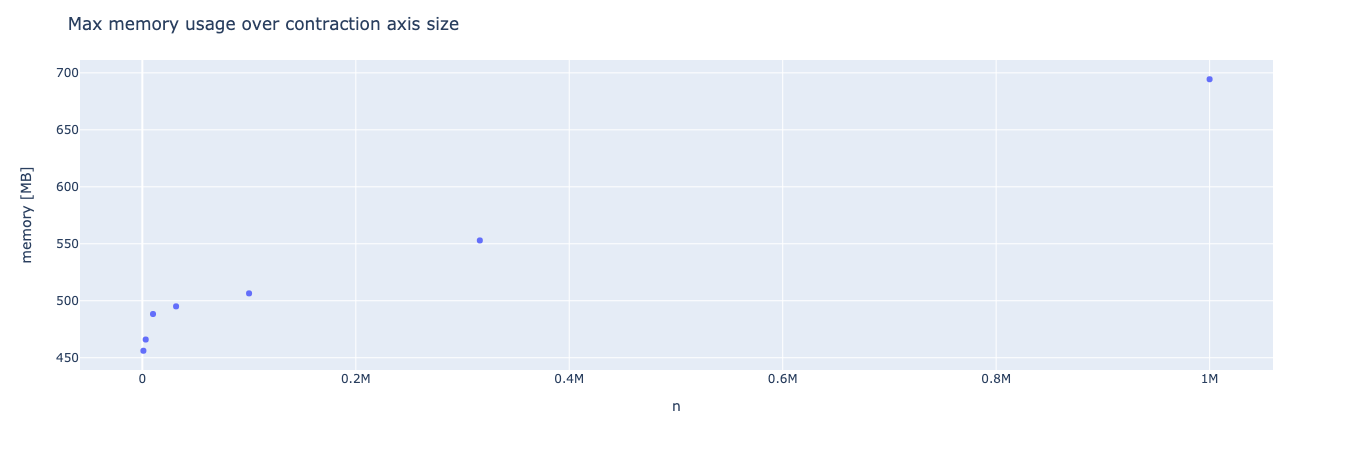

In [14]:
f = px.scatter(new_df.groupby(["n", "m"]).max().reset_index(drop=False),
               x="n", y="mem", labels={"mem": "memory [MB]"})
f.update_layout(title="Max memory usage over contraction axis size")

Memory usage is more or else stable despite increased input size. The impact on execution time depends on the size, for small matrices that fit in memory, original implementation is likely going to be faster, for large ones (larger than memory) the new implementation is likely going to be faster. More on that below.

## Large input, data doesn't fit in memory

My laptop has 32GB of memory. This operation multiplies two matrices of shapes: `(1e3, 1e7)` @ `(1e7, 3)`. Data type is `float64`. This data doesn't fully fit into memory of my laptop, which is the intended test (if you run this on a different machine, you might need to adjust the size).

In [15]:
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:50431 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [16]:
X_7, Y_7 = get_data(n=10**7, m=1000)

In [17]:
# this matrix is transposed before matmul
X_7

dask.array<random_sample, shape=(10000000, 1000), dtype=float64, chunksize=(1000, 250), chunktype=numpy.ndarray>

In [18]:
Y_7

dask.array<random_sample, shape=(10000000, 3), dtype=float64, chunksize=(1000, 3), chunktype=numpy.ndarray>

In [19]:
%%time
resl7, perfl7 = perf_test(matmul, X_7, Y_7)

CPU times: user 1min 15s, sys: 3.56 s, total: 1min 19s
Wall time: 2min 30s


In [20]:
%%time
resl7_org, perfl7_org = perf_test(matmul_org, X_7, Y_7)

CPU times: user 3min 32s, sys: 27.4 s, total: 3min 59s
Wall time: 16min 31s


In [21]:
assert np.allclose(resl7, resl7_org, rtol=0)

Same results, shorter execution time (~2min vs ~15min). The original matmul implementation has a higher memory footprint, which in this case forces spilling to disk (which is very exepnsive).

In [22]:
def graph_mem_and_cpu(perf_org, perf_new, text):
    f = make_subplots(rows=2, cols=1,
                      specs=[[{"secondary_y": True}], [{"secondary_y": True}]],
                      subplot_titles=("Original matmul", "New matmul"))
    
    f_mem = px.scatter(perf_org.results, x="time", y="mem", opacity=.5,)
    f_mem.data[0]["name"] = "memory"
    f_mem.data[0]["showlegend"] = True
    f.add_trace(f_mem.data[0])
    f_cpu = px.scatter(perf_org.results, x="time", y="cpu", color_discrete_sequence=["red"], opacity=.5)
    f_cpu.data[0]["name"] = "cpu"
    f_cpu.data[0]["showlegend"] = True
    f.add_trace(f_cpu.data[0], secondary_y=True)
    
    
    f_mem = px.scatter(perf_new.results, x="time", y="mem", opacity=.5,)
    f.add_trace(f_mem.data[0], row=2, col=1)
    f_cpu = px.scatter(perf_new.results, x="time", y="cpu", color_discrete_sequence=["red"], opacity=.5)
    f.add_trace(f_cpu.data[0], secondary_y=True, row=2, col=1)
    
    
    f.update_yaxes(title_text="CPU [%]", secondary_y=True)
    f.update_yaxes(title_text="memory [MB]", secondary_y=False)
    f.update_xaxes(title_text="time [seconds]", row=2)
    f.update_layout(title=f"Memory/CPU graph ({text})", height=768)
    f.show()

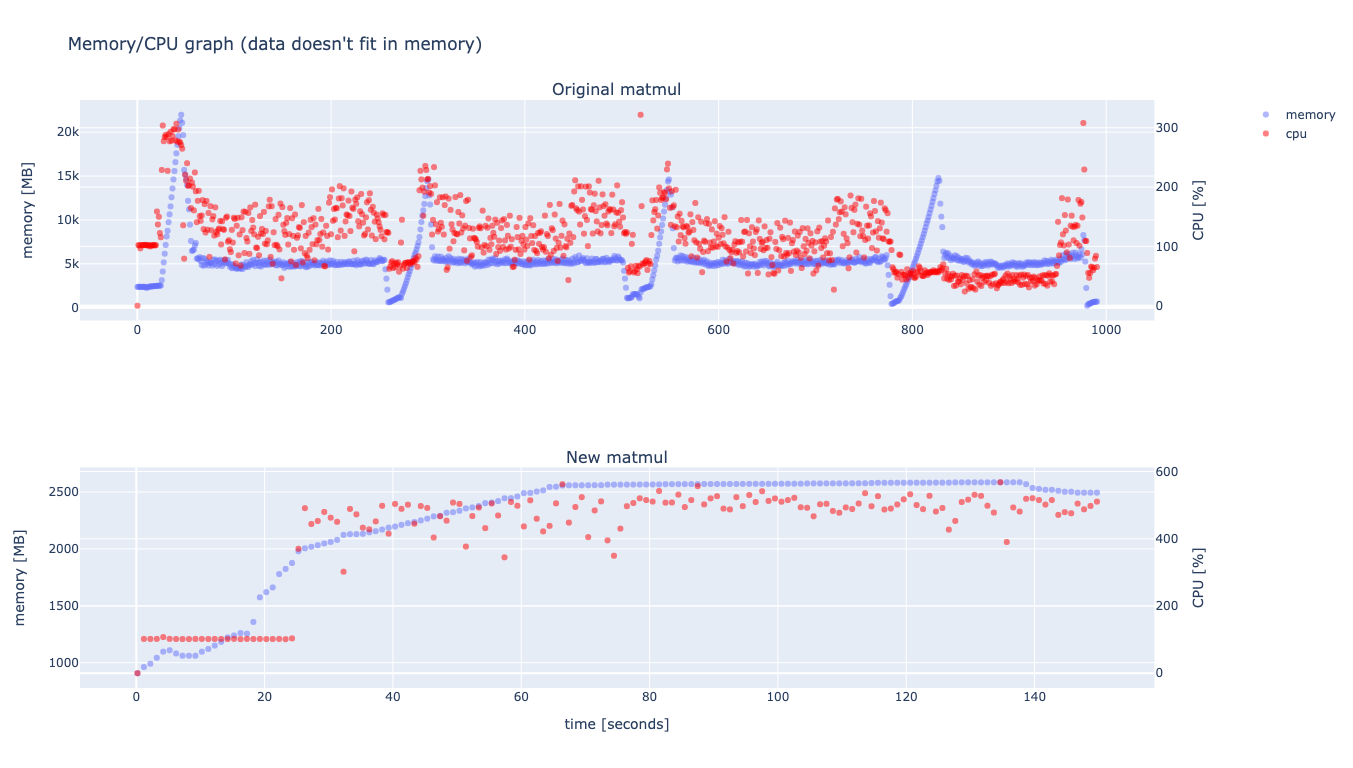

In [23]:
graph_mem_and_cpu(perfl7_org, perfl7, text="data doesn't fit in memory")

Above we can see the impact of the memory footprint and spilling to disk. To validate this, let's see the results for data that fully fits in the memory

## Data fits in memory

In [24]:
# the ful size of these is less than 10GB
X_6, Y_6 = get_data(n=10**6, m=1000)

In [25]:
%%timeit
perf_test(matmul, X_6, Y_6)

15.5 s ± 1.26 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
%%time
resl6, perfl6 = perf_test(matmul, X_6, Y_6)

CPU times: user 6.96 s, sys: 389 ms, total: 7.35 s
Wall time: 15.3 s


In [27]:
%%timeit
perf_test(matmul_org, X_6, Y_6)

11.4 s ± 354 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%%time
resl6_org, perfl6_org = perf_test(matmul_org, X_6, Y_6)

CPU times: user 5.31 s, sys: 342 ms, total: 5.65 s
Wall time: 12.3 s


In [29]:
assert np.allclose(resl6, resl6_org, rtol=0)

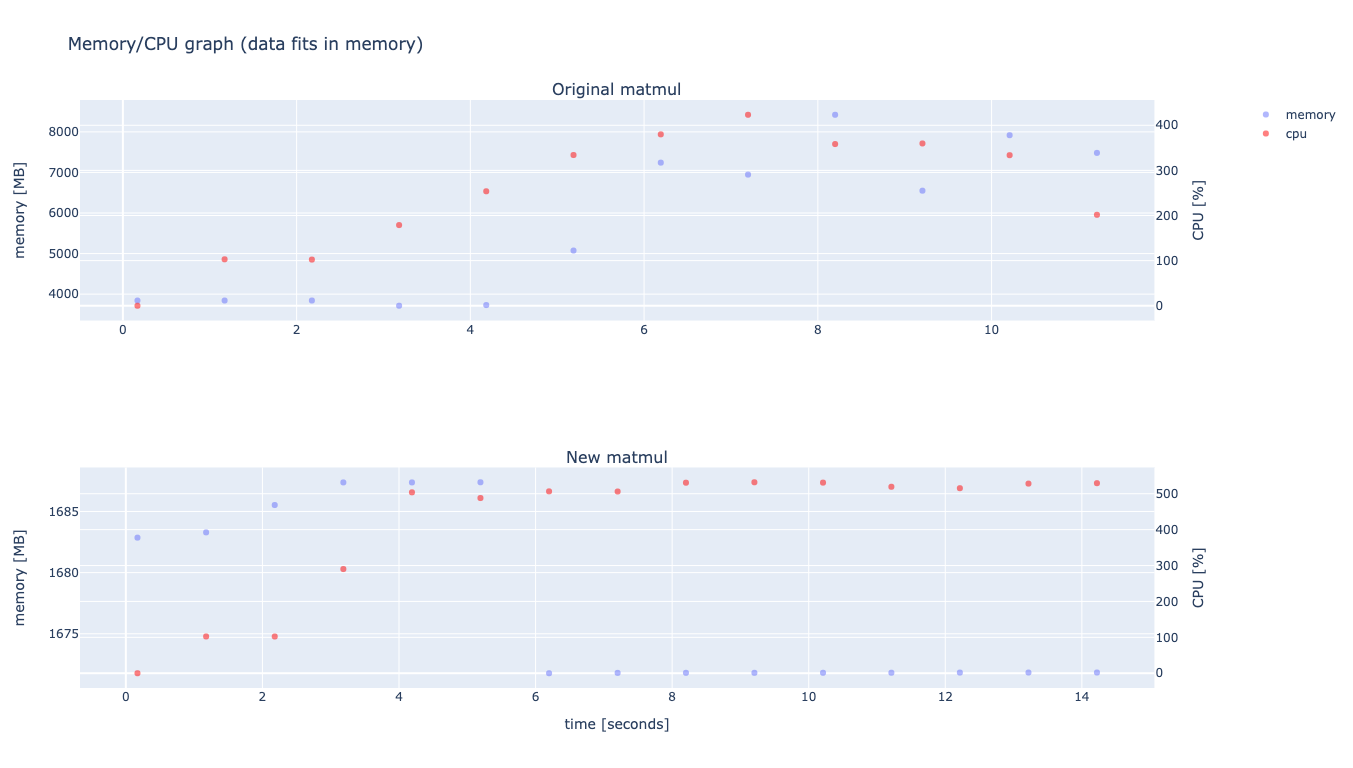

In [30]:
graph_mem_and_cpu(perfl6_org, perfl6, "data fits in memory")

The original implementation is faster at the cost of memory. We could improve the time of the new implementation by adjusting the chunk size to allow more memory for matmul.

In [31]:
X_6_lc, Y_6_lc = get_data(n=10**6, m=1000, chunks=(10000, 1000))

In [32]:
%%timeit
perf_test(matmul, X_6_lc, Y_6_lc)

3.29 s ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [33]:
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:50828 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [34]:
%%time
resl6_lc, perfl6_lc = perf_test(matmul, X_6_lc, Y_6_lc)

CPU times: user 450 ms, sys: 80.6 ms, total: 531 ms
Wall time: 3.22 s


In [35]:
%%timeit
perf_test(matmul_org, X_6_lc, Y_6_lc)

11.3 s ± 9.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
c = get_dask_cluster()
c

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:50959 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 8 Memory: 34.36 GB


In [37]:
%%time
resl6_lc_org, perfl6_lc_org = perf_test(matmul_org, X_6_lc, Y_6_lc)

CPU times: user 685 ms, sys: 150 ms, total: 835 ms
Wall time: 12.2 s


In [38]:
assert np.allclose(resl6_lc, resl6_lc_org, rtol=0)

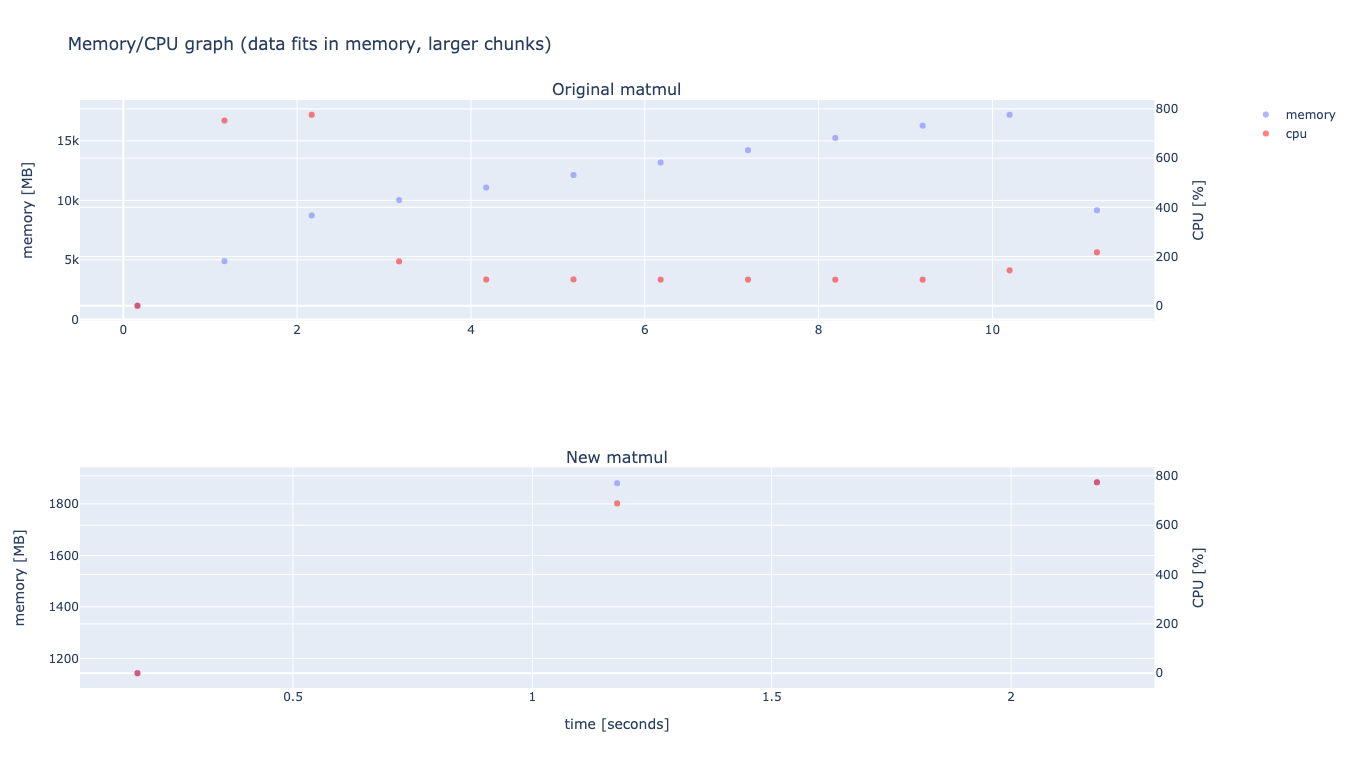

In [39]:
graph_mem_and_cpu(perfl6_lc_org, perfl6_lc, "data fits in memory, larger chunks")

With the new matmul we have better control over the memory and execution time tradeoff. Larger chunks lead to shorter execution times (to some limit obviously), at the cost of memory. Computation is still chunked (no concatenation overhead). In this case by increasing the chunk size, new matmul on average takes ~3s vs ~12s.

Next we can measure what happens if we remove chunking from the contraction axis. This likely will show the concatenation overhead.

In [40]:
X_6_nc, Y_6_nc = get_data(n=10**6, m=1000, chunks=(10**6, 1000))

In [41]:
%%time
resl6_nc, perfl6_nc = perf_test(matmul, X_6_nc, Y_6_nc)

CPU times: user 417 ms, sys: 152 ms, total: 568 ms
Wall time: 11.3 s


In [42]:
%%time
resl6_nc_org, perfl6_nc_org = perf_test(matmul_org, X_6_nc, Y_6_nc)

CPU times: user 728 ms, sys: 213 ms, total: 941 ms
Wall time: 23.3 s


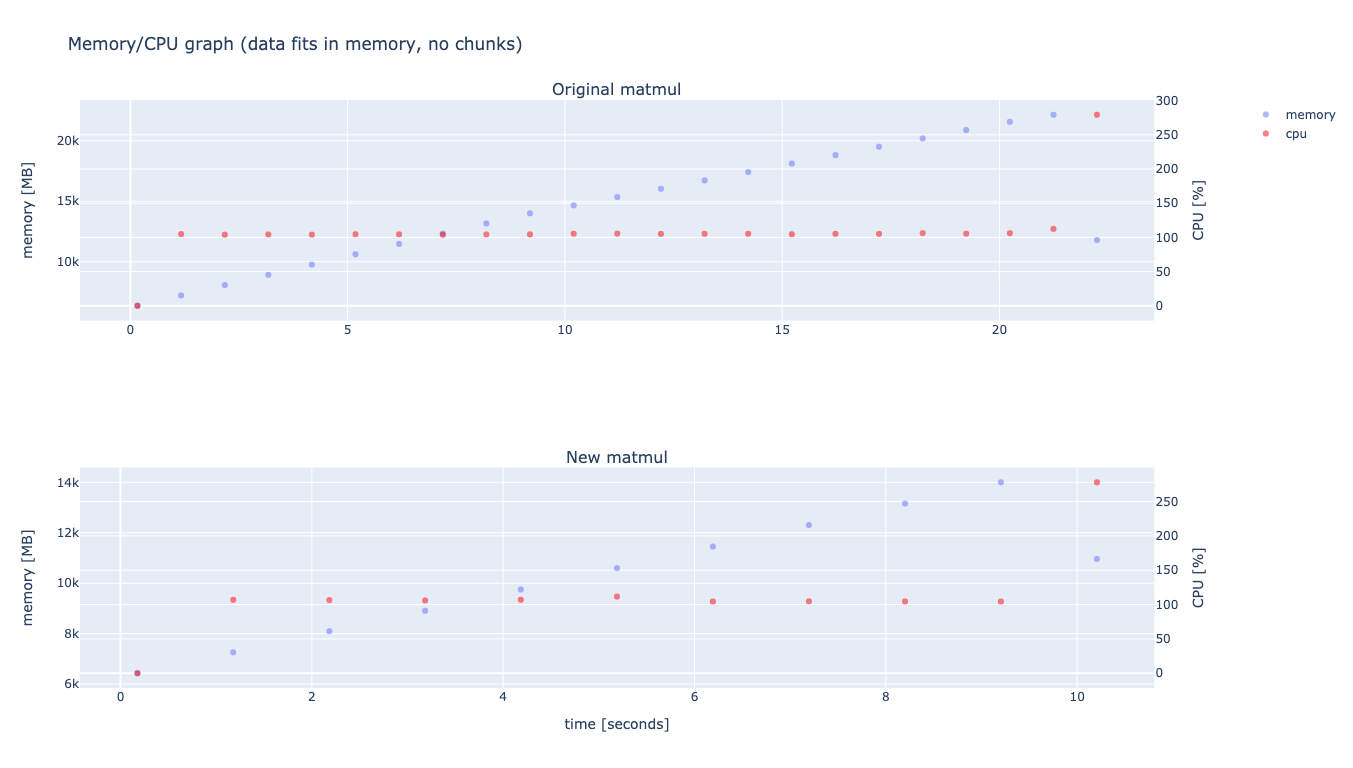

In [43]:
graph_mem_and_cpu(perfl6_nc_org, perfl6_nc, "data fits in memory, no chunks")

## Multiprocess cluster (comm overhead)

In [44]:
# my laptop has 8 cores, let's get 8 processes each with 1 processing thread
c = get_dask_cluster(8)
c

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:51098 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 34.36 GB


In [45]:
%%time
resl6_proc, perfl6_proc = perf_test(matmul, X_6, Y_6)

CPU times: user 8.56 s, sys: 474 ms, total: 9.04 s
Wall time: 10.3 s


In [46]:
%%time
resl6_proc_org, perfl6_proc_org = perf_test(matmul_org, X_6, Y_6)

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory

KilledWorker: ("('matmul-amax-bbdfab12b688ec1464e02b9c382dc425', 0, 0)", <Worker 'tcp://127.0.0.1:51113', name: 4, memory: 0, processing: 1>)

This won't finish on original matmul, let's try to reduce the number of workers to 4 (thus increasing the memory/thread ratio).

In [47]:
c = get_dask_cluster(4)
c

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:51819 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [48]:
%%time
resl6_proc4_org, perfl6_proc4_org = perf_test(matmul_org, X_6, Y_6)

CPU times: user 6.92 s, sys: 453 ms, total: 7.38 s
Wall time: 11.2 s


In [49]:
c = get_dask_cluster(4)
c

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError


Client Scheduler: tcp://127.0.0.1:51934 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [51]:
%%time
resl6_proc4, perfl6_proc4 = perf_test(matmul, X_6, Y_6)

CPU times: user 8.47 s, sys: 491 ms, total: 8.96 s
Wall time: 10.3 s


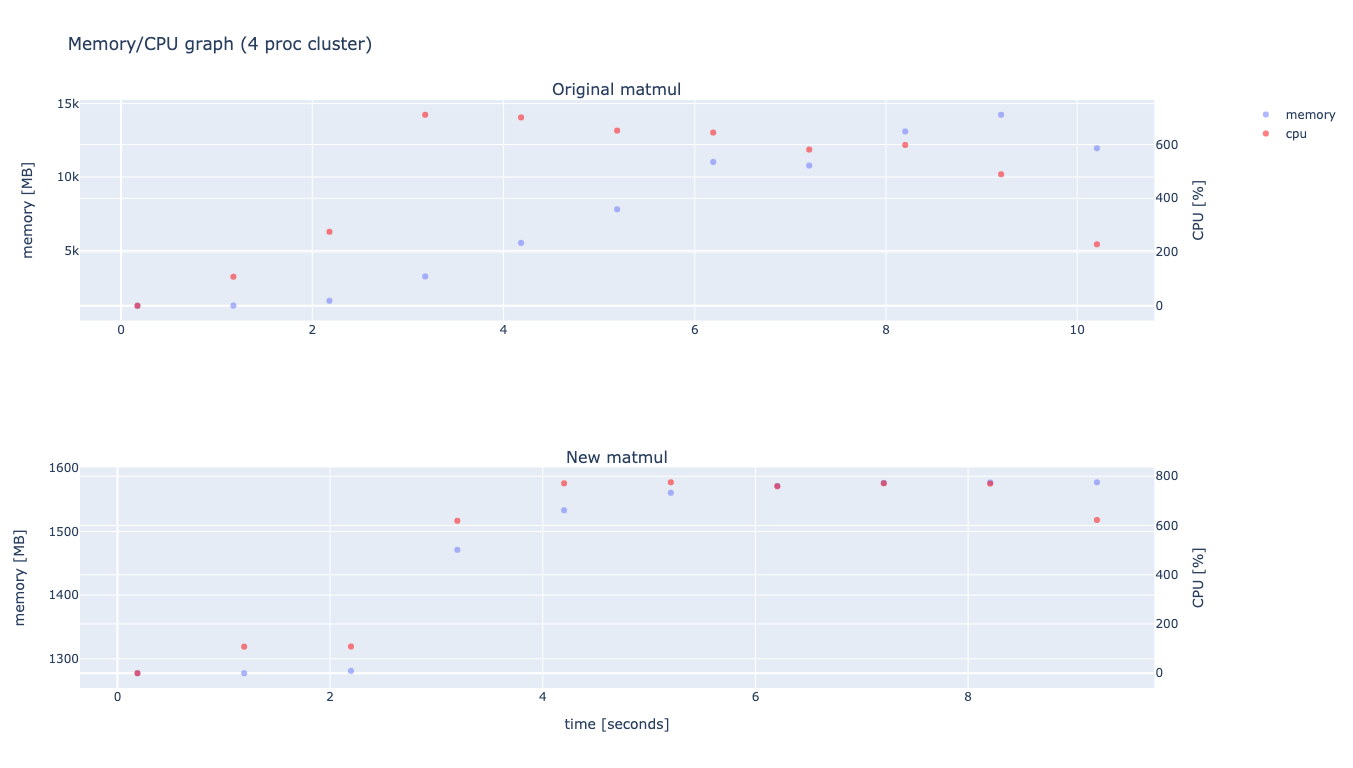

In [52]:
graph_mem_and_cpu(perfl6_proc4_org, perfl6_proc4, "4 proc cluster")